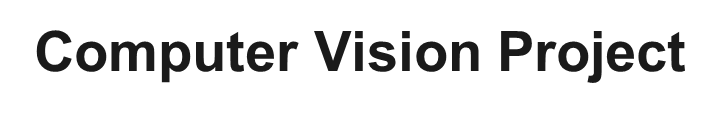

##### By Tiru Wube, Sarah Denlinger, Theo Epstein


### The project is mainly focussed on Classification of images using the big data & machine learning tools and algorithms.



In [ ]:
# Imported important Moduels
import pandas as pd
import pyspark
from pyspark import SparkContext
import cv2
import glob
import numpy as np
from matplotlib import pyplot as plt

#### The data is downloaded from Kaggle at (https://www.kaggle.com/alessiocorrado99/animals10)
#### used HDFS to store animal images
#### used spark enviroment to analyze the image classification by Convolutional Neaural Network(CNN)



In [2]:
# Getting all of the folder names inside the main folder using the glob module
files=glob.glob('raw-img/**', recursive=False)# raw-img is animals' images folder that contains 10 different classes of animals' images files in my local computer
                                              
print(files)

['raw-img\\cane', 'raw-img\\cavallo', 'raw-img\\elefante', 'raw-img\\farfalla', 'raw-img\\gallina', 'raw-img\\gatto', 'raw-img\\mucca', 'raw-img\\pecora', 'raw-img\\ragno', 'raw-img\\scoiattolo']


In [3]:
# Getting all of the filenames from inside each folder
filenames=glob.glob('raw-img/**/**', recursive=False) 
print(len(filenames))

26179


In [4]:
# Taking 1000 image samples from each class out of 26179 images because of the resource limitation
selectedFileNames=[]
for name in files:
    count=0
    i=0
    while count < 1000:
        j=filenames[i]
        if name in j:
            count += 1
            selectedFileNames.append(j)  
        i += 1
filenames=selectedFileNames

In [5]:
# Getting pixels and resize them in to 64 * 64 array, then put all file names and the pixels into two separate lists
filenamelist=[] 
imagearray=[]
for name in selectedFileNames:
    filenamelist.append(name) #putting file names in list
    img=cv2.imread(name, 2) #getting pixels
    imgr=cv2.resize(img, (64, 64))
    imagearray.append(imgr) #putting resized arrays into list

In [6]:
# Change the image arry into lists
imagelist=[]
for i in range(len(imagearray)):
    new_list=imagearray[i].tolist()
    imagelist.append(new_list)

In [11]:
# Creating dataframe after putting the file names and the image list together in a dictionary
dictionary={'FileNames': filenamelist, 'ImageArray': imagelist} 
df=pd.DataFrame.from_dict(dictionary)


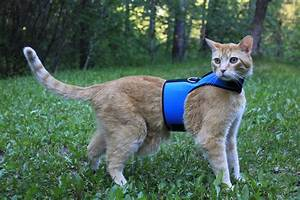

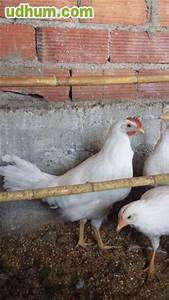

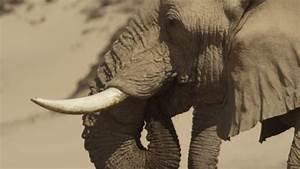

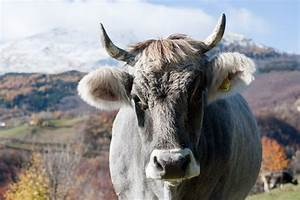

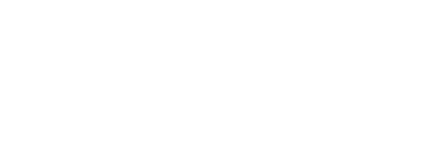

In [15]:
# Displaying some sample images from our dataset
import IPython.display as dp

fig=plt.figure()
file=np.random.choice(df['FileNames'],4)
for i,img in enumerate(file):
    ax= fig.add_subplot(2, 4, i+1)
    image=dp.Image(img, format=None)
    dp.display(image)
    ax.axis('off')
    plt.tight_layout()

#### Saving the image file as CSV format to our local system

In [ ]:
df.to_csv('imagedataset.csv')

#### Saving CSV to HDFS (done in terminal)

## Setting up the spark enviroment in jupyter notebook and import necessary modules

In [8]:
import findspark
findspark.init()

In [95]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, col
import pyspark.sql.functions as sql_f
from pyspark import SparkContext
import seaborn as sns
from pyspark.sql.types import DoubleType
import ast
from keras.utils.np_utils import to_categorical 
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, GlobalMaxPooling2D, MaxPool2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import keras
from keras import optimizers
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix, confusion_matrix
from sklearn.metrics import roc_curve, plot_roc_curve
from sklearn.metrics import auc

#### Reading the image file in spark from Hadoop file system (HDFS). 


In [ ]:
# Extracted file names using regular expression to get animals name and changed them into English name and labled(Encoded) them from 0 to 9.
file='hdfs://localhost:9000/user/sarahdenlinger/data_project/imagedataset.csv'# hdfs directory at local computer
m='local'
sc=SparkSession.builder.master(m).appName(file).getOrCreate()
#loading CSV into pyspark dataframe
df=sc.read.format('csv').option('header', True).option('multiLine', True).load('hdfs://localhost:9000/user/sarahdenlinger/data_project/imagedataset.csv')
#getting animal name from file name and putting english translation into new column in dataframe
df_1=df.withColumn('Animal', when(sql_f.regexp_extract(df.FileNames, r'(?<=-img/).+(?<=/)', 0)=='cane/', 'dog')
                            .when(sql_f.regexp_extract(df.FileNames, r'(?<=-img/).+(?<=/)', 0)=='cavallo/', 'horse')
                            .when(sql_f.regexp_extract(df.FileNames, r'(?<=-img/).+(?<=/)', 0)=='elefante/', 'elephant')
                            .when(sql_f.regexp_extract(df.FileNames, r'(?<=-img/).+(?<=/)', 0)=='farfalla/', 'butterfly')
                            .when(sql_f.regexp_extract(df.FileNames, r'(?<=-img/).+(?<=/)', 0)=='gallina/', 'chicken')
                            .when(sql_f.regexp_extract(df.FileNames, r'(?<=-img/).+(?<=/)', 0)=='gatto/', 'cat')
                            .when(sql_f.regexp_extract(df.FileNames, r'(?<=-img/).+(?<=/)', 0)=='mucca/', 'cow')
                            .when(sql_f.regexp_extract(df.FileNames, r'(?<=-img/).+(?<=/)', 0)=='pecora/', 'sheep')
                            .when(sql_f.regexp_extract(df.FileNames, r'(?<=-img/).+(?<=/)', 0)=='scoiattolo/', 'squirrel')
                            .when(sql_f.regexp_extract(df.FileNames, r'(?<=-img/).+(?<=/)', 0)=='ragno/', 'spider'))
#reference: https://medium.com/swlh/regular-expressions-in-python-and-pyspark-explained-code-included-53cbb22d4117

#putting numeric label for each animal in new column for dataframe
df_1=df_1.withColumn('Label', when(df_1.Animal=='dog', 0)
                              .when(df_1.Animal=='horse', 1)
                              .when(df_1.Animal=='elephant', 2)
                              .when(df_1.Animal=='butterfly', 3)
                              .when(df_1.Animal=='chicken', 4)
                              .when(df_1.Animal=='cat', 5)
                              .when(df_1.Animal=='cow', 6)
                              .when(df_1.Animal=='sheep', 7)
                              .when(df_1.Animal=='squirrel', 8)
                              .when(df_1.Animal=='spider', 9))


#### Spark Dataframe displaying the animals name with their encoded values along ImageArray and FileNames columns

In [12]:
df_1.show()

+---+--------------------+--------------------+-------+-----+
|_c0|           FileNames|          ImageArray| Animal|Label|
+---+--------------------+--------------------+-------+-----+
|  0|raw-img/gallina/O...|[[190, 199, 208, ...|chicken|    4|
|  1|raw-img/gallina/O...|[[102, 154, 152, ...|chicken|    4|
|  2|raw-img/gallina/O...|[[83, 95, 113, 11...|chicken|    4|
|  3|raw-img/gallina/6...|[[93, 185, 78, 61...|chicken|    4|
|  4|raw-img/gallina/O...|[[76, 84, 78, 64,...|chicken|    4|
|  5|raw-img/gallina/O...|[[213, 210, 204, ...|chicken|    4|
|  6|raw-img/gallina/O...|[[251, 251, 251, ...|chicken|    4|
|  7|raw-img/gallina/O...|[[105, 106, 105, ...|chicken|    4|
|  8|raw-img/gallina/O...|[[172, 197, 189, ...|chicken|    4|
|  9|raw-img/gallina/O...|[[37, 33, 30, 32,...|chicken|    4|
| 10|raw-img/gallina/6...|[[79, 50, 45, 57,...|chicken|    4|
| 11|raw-img/gallina/O...|[[251, 251, 251, ...|chicken|    4|
| 12|raw-img/gallina/O...|[[108, 127, 140, ...|chicken|    4|
| 13|raw

## Preparing the image dataframe to fit to the model

In [13]:
df_1=df_1.rdd.map(lambda x: (x['FileNames'], ast.literal_eval(x['ImageArray']), x['Animal'], x['Label']))
df_1=df_1.toDF(['FileNames', 'ImageArray', 'Animal', 'Label'])

In [14]:
# Getting features from the dataframe
imgarr_list=df_1.select('ImageArray').collect() 
features1=[np.array(row.ImageArray, np.uint8) for row in imgarr_list]

#### A sample array from features1

In [15]:
features1[0]

array([[190, 199, 208, ...,  82,  94,  83],
       [197, 206, 212, ...,  81,  82,  93],
       [200, 212, 212, ...,  84,  69,  86],
       ...,
       [147, 156, 164, ..., 126, 128, 131],
       [143, 159, 155, ..., 117, 122, 153],
       [138, 146, 161, ...,  52,  47,  46]], dtype=uint8)

#### A picture from the above arry pixels

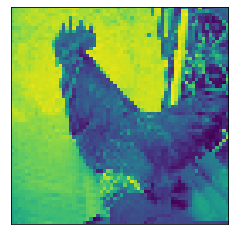

In [16]:
plt.imshow(features1[0]  )
plt.xticks([]), plt.yticks([])  
plt.show()

In [17]:
for feat in features1:
    for f in feat:
        np.array(f, np.uint8)

In [18]:
# Scaling the image pixels from 0 to 255 to 0 to 1 
features1=[f/255 for f in features1]

In [22]:
features1[0]

array([[0.74509804, 0.78039216, 0.81568627, ..., 0.32156863, 0.36862745,
        0.3254902 ],
       [0.77254902, 0.80784314, 0.83137255, ..., 0.31764706, 0.32156863,
        0.36470588],
       [0.78431373, 0.83137255, 0.83137255, ..., 0.32941176, 0.27058824,
        0.3372549 ],
       ...,
       [0.57647059, 0.61176471, 0.64313725, ..., 0.49411765, 0.50196078,
        0.51372549],
       [0.56078431, 0.62352941, 0.60784314, ..., 0.45882353, 0.47843137,
        0.6       ],
       [0.54117647, 0.57254902, 0.63137255, ..., 0.20392157, 0.18431373,
        0.18039216]])

In [19]:
# Getting labels out of the dataframe
label_list=df_1.select('Label').collect()
labels=[row.Label for row in label_list] 

In [23]:
# Assinging variables name X for features and y for targate variable or labels
X=features1
y=np.array(labels)

In [24]:
# Changing the y value into arrays with a series of 0s and 1s for each class
X=np.array(features1)
y=to_categorical(labels, num_classes=10)

In [25]:
# Chaning the data type for both X and y value into float32 to fit into the model
X=np.asarray(X).astype(np.float32)
y=np.asarray(y).astype(np.float32)

# Model Fitting

#### Splitting the data for train and test, to use the training datset to train our model and test to evaluate the model

In [29]:
X2=X.reshape(len(X), 64, 64, 1)
y2=y

In [30]:
X_train2, X_test2, y_train2, y_test2=train_test_split(X2, y2, train_size=0.8, random_state=3)

## 1. Model Convolutional Neural Network with 3 hidden layers 150 Epochs
#### In this model we have kernel size 3, activation function Relu for input and hidden layers and softmax for output layer, pooling 2*2,Dropout 0.5 and optimizer Adam 0.001


In [199]:
model_14= Sequential()

model_14.add(Conv2D(16, kernel_size=3, activation='relu', input_shape=(64, 64, 1)))
model_14.add(MaxPool2D(2,2))
model_14.add(Conv2D(32, kernel_size=3, activation='relu'))
model_14.add(MaxPool2D(2,2))
model_14.add(Conv2D(64, kernel_size=3, activation='relu'))
model_14.add(MaxPool2D(2,2))
model_14.add(Dropout(0.5))
model_14.add(Flatten())
model_14.add(Dense(50, activation='relu'))
model_14.add(Dropout(0.5))
model_14.add(Dense(10, activation='softmax'))
adam=Adam(0.001) 
model_14.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [200]:
model_14history=model_14.fit(X_train2, y_train2, batch_size=160, validation_split=0.2, epochs=150, verbose=1)

Epoch 1/150
40/40 [==============================] - 7s 157ms/step - loss: 2.3027 - accuracy: 0.1045 - val_loss: 2.2842 - val_accuracy: 0.1256
Epoch 2/150
40/40 [==============================] - 6s 156ms/step - loss: 2.2745 - accuracy: 0.1338 - val_loss: 2.2095 - val_accuracy: 0.1600
Epoch 3/150
40/40 [==============================] - 7s 167ms/step - loss: 2.2162 - accuracy: 0.1824 - val_loss: 2.1899 - val_accuracy: 0.1869
Epoch 4/150
40/40 [==============================] - 6s 163ms/step - loss: 2.1809 - accuracy: 0.2098 - val_loss: 2.0437 - val_accuracy: 0.2806
Epoch 5/150
40/40 [==============================] - 7s 167ms/step - loss: 2.0939 - accuracy: 0.2373 - val_loss: 1.9913 - val_accuracy: 0.3113
Epoch 6/150
40/40 [==============================] - 7s 166ms/step - loss: 2.0130 - accuracy: 0.2739 - val_loss: 1.8929 - val_accuracy: 0.3587
Epoch 7/150
40/40 [==============================] - 7s 168ms/step - loss: 1.9527 - accuracy: 0.3001 - val_loss: 1.8234 - val_accuracy: 0.3619

Epoch 58/150
40/40 [==============================] - 7s 180ms/step - loss: 1.0801 - accuracy: 0.6110 - val_loss: 1.2695 - val_accuracy: 0.5669
Epoch 59/150
40/40 [==============================] - 7s 178ms/step - loss: 1.0723 - accuracy: 0.6090 - val_loss: 1.2803 - val_accuracy: 0.5612
Epoch 60/150
40/40 [==============================] - 7s 173ms/step - loss: 1.0647 - accuracy: 0.6204 - val_loss: 1.2721 - val_accuracy: 0.5644
Epoch 61/150
40/40 [==============================] - 7s 173ms/step - loss: 1.0475 - accuracy: 0.6366 - val_loss: 1.2772 - val_accuracy: 0.5681
Epoch 62/150
40/40 [==============================] - 7s 173ms/step - loss: 1.0678 - accuracy: 0.6176 - val_loss: 1.3122 - val_accuracy: 0.5625
Epoch 63/150
40/40 [==============================] - 7s 174ms/step - loss: 1.0901 - accuracy: 0.6052 - val_loss: 1.2614 - val_accuracy: 0.5700
Epoch 64/150
40/40 [==============================] - 7s 173ms/step - loss: 1.0563 - accuracy: 0.6227 - val_loss: 1.2765 - val_accuracy:

Epoch 115/150
40/40 [==============================] - 7s 178ms/step - loss: 0.8376 - accuracy: 0.6930 - val_loss: 1.2948 - val_accuracy: 0.5825
Epoch 116/150
40/40 [==============================] - 7s 178ms/step - loss: 0.8336 - accuracy: 0.6927 - val_loss: 1.2838 - val_accuracy: 0.5806
Epoch 117/150
40/40 [==============================] - 7s 180ms/step - loss: 0.8564 - accuracy: 0.6916 - val_loss: 1.2992 - val_accuracy: 0.5688
Epoch 118/150
40/40 [==============================] - 7s 185ms/step - loss: 0.8362 - accuracy: 0.6886 - val_loss: 1.2998 - val_accuracy: 0.5713
Epoch 119/150
40/40 [==============================] - 7s 180ms/step - loss: 0.7946 - accuracy: 0.7036 - val_loss: 1.3182 - val_accuracy: 0.5738
Epoch 120/150
40/40 [==============================] - 7s 178ms/step - loss: 0.8218 - accuracy: 0.7101 - val_loss: 1.3078 - val_accuracy: 0.5656
Epoch 121/150
40/40 [==============================] - 7s 178ms/step - loss: 0.8127 - accuracy: 0.7088 - val_loss: 1.3201 - val_ac

### Model accuracy and the least loss at epoch 150 in traning and test datasets

In [202]:
acc_m_14train=model_14.evaluate(X_train2, y_train2, verbose=1)
print('Train Score:', acc_m_14train[0]) 
print('Train Accuracy:', acc_m_14train[1])
acc_m_14test=model_14.evaluate(X_test2, y_test2, verbose=1)
print('Test Score:', acc_m_14test[0]) 
print('Test Accuracy:', acc_m_14test[1])

250/250 [==============================] - 2s 8ms/step - loss: 0.4850 - accuracy: 0.8845
Train Score: 0.485047847032547
Train Accuracy: 0.8845000267028809
63/63 [==============================] - 0s 7ms/step - loss: 1.4061 - accuracy: 0.5520
Test Score: 1.4061168432235718
Test Accuracy: 0.5519999861717224


### Plotting the accuracy versus epoch graph for this model to display the accuracies for train and validation datasets

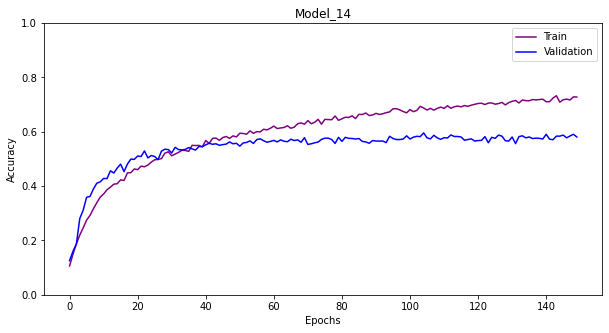

In [203]:
plt.plot(model_14history.history['accuracy'], label = 'accuracy', color='purple')
plt.plot(model_14history.history['val_accuracy'], label = 'val_accuracy', color='blue') 
plt.legend(['Train', 'Validation'])
plt.title('Model_14')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0, 1.0]);

### The Confusion matrix to display how many images are predicted correct and how many are wrong

In [204]:
predictm_14=model_14.predict(X_test2)
expectm_14=y_test2
conf_matrix_m14=confusion_matrix(y_test2.argmax(axis=1), predictm_14.argmax(axis=1))
print(conf_matrix_m14)

[[ 83   8  10   1  12  35  13   5  15   2]
 [ 21 115  28   4   0   6  32  11   5   4]
 [  6  13 130   1  10   7  20  12  15   5]
 [  5   3   3 111   6  10   0   0  20  27]
 [  6   2  11   5 105   8   6   8  20   6]
 [ 45   4   4  11   4 103   3   8  22  12]
 [  9  20  26   0   9   6 100  24   5   0]
 [ 13   5  22   4  11  10  40  85   7   2]
 [ 12   1   9  10  14  16   4   3 111  12]
 [  9   0   2  19   8  12   1   3  15 134]]


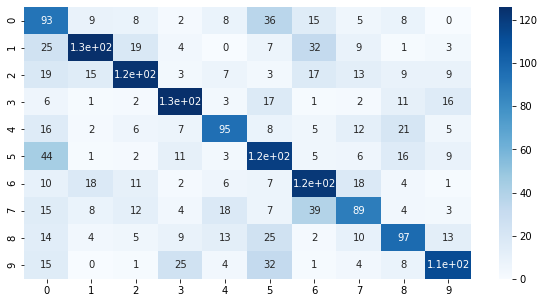

In [205]:
sns.heatmap(conf_matrix_m14, annot=True, cmap='Blues');

## 2. Model Convolutional Neural Network with 3 hidden layers 200 Epochs
#### In this model we have kernel size 3, activation function Relu for input and hidden layers and softmax for output layer, pooling 2*2,Dropout 0.5 and optimizer Adam 0.001

In [206]:
model_15= Sequential()

model_15.add(Conv2D(16, kernel_size=3, activation='relu', input_shape=(64, 64, 1)))
model_15.add(MaxPool2D(2,2))
model_15.add(Conv2D(32, kernel_size=3, activation='relu'))
model_15.add(MaxPool2D(2,2))
model_15.add(Conv2D(64, kernel_size=3, activation='relu'))
model_15.add(MaxPool2D(2,2))
model_15.add(Dropout(0.5))
model_15.add(Flatten())
model_15.add(Dense(50, activation='relu'))
model_15.add(Dropout(0.5))
model_15.add(Dense(10, activation='softmax'))
adam=Adam(0.001) 
model_15.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [207]:
model_15history=model_15.fit(X_train2, y_train2, batch_size=160, validation_split=0.2, epochs=200, verbose=1)

Epoch 1/200
40/40 [==============================] - 7s 158ms/step - loss: 2.3051 - accuracy: 0.1034 - val_loss: 2.2891 - val_accuracy: 0.1700
Epoch 2/200
40/40 [==============================] - 6s 155ms/step - loss: 2.2836 - accuracy: 0.1331 - val_loss: 2.1960 - val_accuracy: 0.2469
Epoch 3/200
40/40 [==============================] - 6s 163ms/step - loss: 2.2037 - accuracy: 0.2029 - val_loss: 2.0954 - val_accuracy: 0.2763
Epoch 4/200
40/40 [==============================] - 6s 162ms/step - loss: 2.1223 - accuracy: 0.2333 - val_loss: 2.0304 - val_accuracy: 0.3094
Epoch 5/200
40/40 [==============================] - 7s 171ms/step - loss: 2.0657 - accuracy: 0.2576 - val_loss: 1.9316 - val_accuracy: 0.3481
Epoch 6/200
40/40 [==============================] - 7s 170ms/step - loss: 1.9949 - accuracy: 0.2835 - val_loss: 1.8801 - val_accuracy: 0.3719
Epoch 7/200
40/40 [==============================] - 7s 174ms/step - loss: 1.9399 - accuracy: 0.3177 - val_loss: 1.7888 - val_accuracy: 0.4069

Epoch 58/200
40/40 [==============================] - 8s 197ms/step - loss: 1.0758 - accuracy: 0.6256 - val_loss: 1.2798 - val_accuracy: 0.5544
Epoch 59/200
40/40 [==============================] - 7s 186ms/step - loss: 1.0567 - accuracy: 0.6316 - val_loss: 1.3262 - val_accuracy: 0.5387
Epoch 60/200
40/40 [==============================] - 7s 185ms/step - loss: 1.0501 - accuracy: 0.6214 - val_loss: 1.2986 - val_accuracy: 0.5519
Epoch 61/200
40/40 [==============================] - 7s 184ms/step - loss: 1.0473 - accuracy: 0.6298 - val_loss: 1.3297 - val_accuracy: 0.5412
Epoch 62/200
40/40 [==============================] - 7s 185ms/step - loss: 1.0921 - accuracy: 0.6072 - val_loss: 1.2865 - val_accuracy: 0.5500
Epoch 63/200
40/40 [==============================] - 7s 182ms/step - loss: 1.0459 - accuracy: 0.6271 - val_loss: 1.3244 - val_accuracy: 0.5431
Epoch 64/200
40/40 [==============================] - 7s 178ms/step - loss: 1.0581 - accuracy: 0.6187 - val_loss: 1.2792 - val_accuracy:

Epoch 115/200
40/40 [==============================] - 7s 183ms/step - loss: 0.8185 - accuracy: 0.7055 - val_loss: 1.3370 - val_accuracy: 0.5531
Epoch 116/200
40/40 [==============================] - 7s 184ms/step - loss: 0.8021 - accuracy: 0.7068 - val_loss: 1.3503 - val_accuracy: 0.5575
Epoch 117/200
40/40 [==============================] - 7s 181ms/step - loss: 0.8151 - accuracy: 0.7115 - val_loss: 1.3158 - val_accuracy: 0.5631
Epoch 118/200
40/40 [==============================] - 7s 183ms/step - loss: 0.8095 - accuracy: 0.7040 - val_loss: 1.3478 - val_accuracy: 0.5656
Epoch 119/200
40/40 [==============================] - 7s 183ms/step - loss: 0.7879 - accuracy: 0.7120 - val_loss: 1.3472 - val_accuracy: 0.5519
Epoch 120/200
40/40 [==============================] - 7s 184ms/step - loss: 0.7998 - accuracy: 0.7008 - val_loss: 1.3663 - val_accuracy: 0.5519
Epoch 121/200
40/40 [==============================] - 7s 183ms/step - loss: 0.8000 - accuracy: 0.7132 - val_loss: 1.3409 - val_ac

### Model accuracy and the least loss at epoch 200 in traning and test datasets

In [208]:
acc_m_15train=model_15.evaluate(X_train2, y_train2, verbose=1)
print('Train Score:', acc_m_15train[0]) 
print('Train Accuracy:', acc_m_15train[1])
acc_m_15test=model_15.evaluate(X_test2, y_test2, verbose=1)
print('Test Score:', acc_m_15test[0]) 
print('Test Accuracy:', acc_m_15test[1])

250/250 [==============================] - 2s 8ms/step - loss: 0.4112 - accuracy: 0.9054
Train Score: 0.41119781136512756
Train Accuracy: 0.9053750038146973
63/63 [==============================] - 1s 8ms/step - loss: 1.4642 - accuracy: 0.5545
Test Score: 1.464232087135315
Test Accuracy: 0.5544999837875366


### Plotting the accuracy versus epoch graph for model_15 to display the accuracies for train and validation datasets

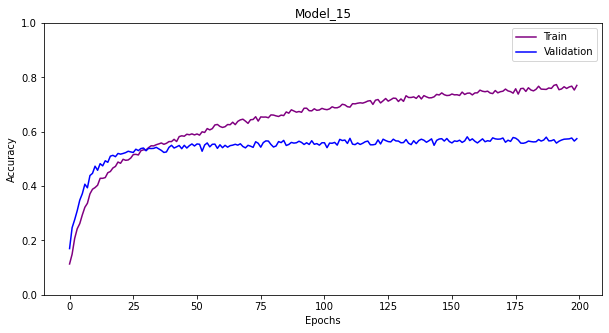

In [237]:
plt.plot(model_15history.history['accuracy'], label = 'accuracy', color='purple')
plt.plot(model_15history.history['val_accuracy'], label = 'val_accuracy', color='blue') 
plt.legend(['Train', 'Validation'])
plt.title('Model_15')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0, 1.0]);

### The Confusion matrix to display how many images are predicted correct and how many are wrong for model_15

In [246]:
predictm_15=model_15.predict(X_test2)
expectm_15=y_test2
conf_matrix_m15=confusion_matrix(y_test2.argmax(axis=1), predictm_15.argmax(axis=1))
print(conf_matrix_m15)

[[ 86  14  11   3  13  23  15   7  10   2]
 [ 15 129  31   6   2   1  27   9   4   2]
 [  9  17 136   1   8   2  19   7  12   8]
 [  8   4   4 116   8  10   2   1  15  17]
 [  6   4  10   7 105   4   5  11  17   8]
 [ 49   4   3  12   4 101   1   6  22  14]
 [  6  19  23   1   9   4 116  16   5   0]
 [ 13  15  23   5  14   5  32  88   3   1]
 [ 15   8   4   8  16  15   5   4 107  10]
 [ 15   1   4  22  10   9   0   0  17 125]]


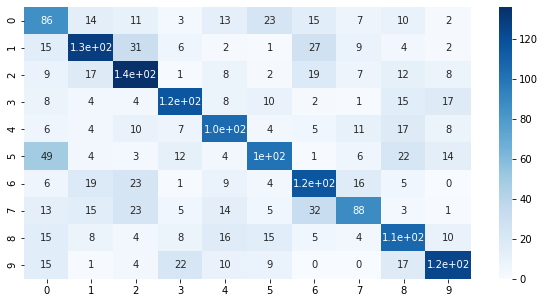

In [255]:
sns.heatmap(conf_matrix_m15, annot=True, cmap='Blues');

## 3. Model Convolutional Neural Network with 3 hidden layers 200 Epochs
#### In this model one additional dropout layer is added to decrease overfitting and increased batch size 500

In [212]:
model_17= Sequential()

model_17.add(Conv2D(16, kernel_size=3, activation='relu', input_shape=(64, 64, 1)))
model_17.add(MaxPool2D(2,2))
model_17.add(Conv2D(32, kernel_size=3, activation='relu'))
model_17.add(MaxPool2D(2,2))
model_17.add(Dropout(0.5))
model_17.add(Conv2D(64, kernel_size=3, activation='relu'))
model_17.add(MaxPool2D(2,2))
model_17.add(Dropout(0.5))
model_17.add(Flatten())
model_17.add(Dense(50, activation='relu'))
model_17.add(Dropout(0.5))
model_17.add(Dense(10, activation='softmax'))
adam=Adam(0.001) 
model_17.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [213]:
model_17history=model_17.fit(X_train2, y_train2, batch_size=500, validation_split=0.2, epochs=200, verbose=1)

Epoch 1/200
13/13 [==============================] - 7s 450ms/step - loss: 2.3110 - accuracy: 0.0973 - val_loss: 2.2998 - val_accuracy: 0.1275
Epoch 2/200
13/13 [==============================] - 6s 430ms/step - loss: 2.2970 - accuracy: 0.1136 - val_loss: 2.2893 - val_accuracy: 0.1206
Epoch 3/200
13/13 [==============================] - 6s 450ms/step - loss: 2.2801 - accuracy: 0.1275 - val_loss: 2.2508 - val_accuracy: 0.1594
Epoch 4/200
13/13 [==============================] - 6s 446ms/step - loss: 2.2472 - accuracy: 0.1590 - val_loss: 2.2100 - val_accuracy: 0.1931
Epoch 5/200
13/13 [==============================] - 6s 477ms/step - loss: 2.2166 - accuracy: 0.1817 - val_loss: 2.1668 - val_accuracy: 0.2206
Epoch 6/200
13/13 [==============================] - 6s 500ms/step - loss: 2.1977 - accuracy: 0.1896 - val_loss: 2.1442 - val_accuracy: 0.2394
Epoch 7/200
13/13 [==============================] - 7s 532ms/step - loss: 2.1654 - accuracy: 0.1970 - val_loss: 2.1269 - val_accuracy: 0.2294

Epoch 58/200
13/13 [==============================] - 7s 533ms/step - loss: 1.5350 - accuracy: 0.4508 - val_loss: 1.4538 - val_accuracy: 0.4950
Epoch 59/200
13/13 [==============================] - 7s 527ms/step - loss: 1.5392 - accuracy: 0.4470 - val_loss: 1.4574 - val_accuracy: 0.4919
Epoch 60/200
13/13 [==============================] - 7s 509ms/step - loss: 1.5698 - accuracy: 0.4383 - val_loss: 1.4678 - val_accuracy: 0.5019
Epoch 61/200
13/13 [==============================] - 7s 521ms/step - loss: 1.5329 - accuracy: 0.4517 - val_loss: 1.4459 - val_accuracy: 0.5069
Epoch 62/200
13/13 [==============================] - 7s 526ms/step - loss: 1.5413 - accuracy: 0.4513 - val_loss: 1.4401 - val_accuracy: 0.5150
Epoch 63/200
13/13 [==============================] - 7s 517ms/step - loss: 1.5447 - accuracy: 0.4510 - val_loss: 1.4272 - val_accuracy: 0.5094
Epoch 64/200
13/13 [==============================] - 7s 528ms/step - loss: 1.5034 - accuracy: 0.4706 - val_loss: 1.4464 - val_accuracy:

Epoch 115/200
13/13 [==============================] - 7s 530ms/step - loss: 1.3210 - accuracy: 0.5317 - val_loss: 1.2907 - val_accuracy: 0.5494
Epoch 116/200
13/13 [==============================] - 7s 526ms/step - loss: 1.3064 - accuracy: 0.5385 - val_loss: 1.2927 - val_accuracy: 0.5431
Epoch 117/200
13/13 [==============================] - 7s 527ms/step - loss: 1.2824 - accuracy: 0.5474 - val_loss: 1.2811 - val_accuracy: 0.5400
Epoch 118/200
13/13 [==============================] - 7s 525ms/step - loss: 1.2624 - accuracy: 0.5458 - val_loss: 1.2818 - val_accuracy: 0.5481
Epoch 119/200
13/13 [==============================] - 7s 525ms/step - loss: 1.2809 - accuracy: 0.5392 - val_loss: 1.2756 - val_accuracy: 0.5600
Epoch 120/200
13/13 [==============================] - 7s 535ms/step - loss: 1.2811 - accuracy: 0.5378 - val_loss: 1.2840 - val_accuracy: 0.5431
Epoch 121/200
13/13 [==============================] - 7s 534ms/step - loss: 1.2937 - accuracy: 0.5404 - val_loss: 1.2837 - val_ac

### Model accuracy and the least loss at epoch 200 in traning and test datasets for model_17

In [214]:
acc_m_17train=model_17.evaluate(X_train2, y_train2, verbose=1)
print('Train Score:', acc_m_17train[0]) 
print('Train Accuracy:', acc_m_17train[1])
acc_m_17test=model_17.evaluate(X_test2, y_test2, verbose=1)
print('Test Score:', acc_m_17test[0]) 
print('Test Accuracy:', acc_m_17test[1])

250/250 [==============================] - 2s 9ms/step - loss: 0.7830 - accuracy: 0.7803
Train Score: 0.7829602956771851
Train Accuracy: 0.7802500128746033
63/63 [==============================] - 0s 7ms/step - loss: 1.2688 - accuracy: 0.5590
Test Score: 1.2688252925872803
Test Accuracy: 0.5590000152587891


### Plotting the accuracy versus epoch graph for model_17 to display the accuracies for train and validation datasets

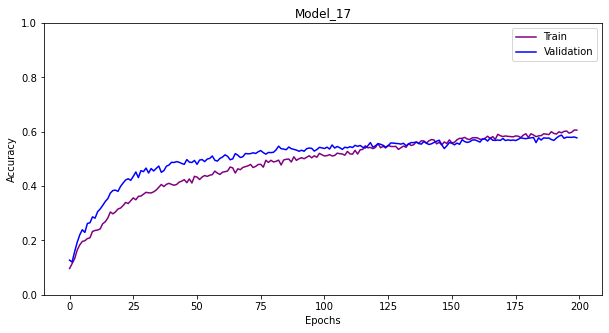

In [239]:
plt.plot(model_17history.history['accuracy'], label = 'accuracy', color='purple')
plt.plot(model_17history.history['val_accuracy'], label = 'val_accuracy', color='blue') 
plt.legend(['Train', 'Validation'])
plt.title('Model_17')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0, 1.0]);

### The Confusion matrix to display how many images are predicted correct and how many are wrong for model_17

In [248]:
predictm_17=model_17.predict(X_test2)
expectm_17=y_test2
conf_matrix_m17=confusion_matrix(y_test2.argmax(axis=1), predictm_17.argmax(axis=1))
print(conf_matrix_m17)

[[ 82  13   9   1  11  28  10   6  17   7]
 [ 13 127  28   5   1   3  23  17   4   5]
 [  6  10 137   1  12   3  15  11  14  10]
 [  3   2   2 119   8   5   0   0  16  30]
 [  7   2   8   2 103   3   2   8  29  13]
 [ 41   5   2   8   4  98   2   5  27  24]
 [ 10  17  17   1   5   3  97  43   5   1]
 [ 11   4  10   1  16   4  34 105   9   5]
 [ 14   3   6   3  12  16   1   7 110  20]
 [  8   2   1  17   6  14   0   1  14 140]]


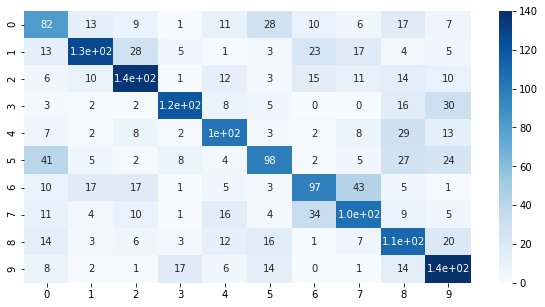

In [257]:
sns.heatmap(conf_matrix_m17, annot=True, cmap='Blues');

## 4. Model Convolutional Neural Network with 3 hidden layers 300 Epochs

#### In this model the number of epochs was increased to see if the accuracy would improve.

In [ ]:
model_24= Sequential()

model_24.add(Conv2D(16, kernel_size=3, activation='relu', input_shape=(64, 64, 1)))
model_24.add(MaxPool2D(2,2))
model_24.add(Conv2D(32, kernel_size=3, activation='relu'))
model_24.add(MaxPool2D(2,2))
model_24.add(Dropout(0.5))
model_24.add(Conv2D(64, kernel_size=3, activation='relu'))
model_24.add(MaxPool2D(2,2))
model_24.add(Dropout(0.5))
model_24.add(Flatten())
model_24.add(Dense(50, activation='relu'))
model_24.add(Dropout(0.5))
model_24.add(Dense(10, activation='softmax'))
adam=Adam(0.001) 
model_24.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [235]:
model_24history=model_24.fit(X_train2, y_train2, batch_size=500, validation_split=0.2, epochs=300, verbose=1)

Epoch 1/300
13/13 [==============================] - 6s 434ms/step - loss: 2.3153 - accuracy: 0.1063 - val_loss: 2.3025 - val_accuracy: 0.0975
Epoch 2/300
13/13 [==============================] - 5s 411ms/step - loss: 2.3015 - accuracy: 0.1131 - val_loss: 2.3016 - val_accuracy: 0.1256
Epoch 3/300
13/13 [==============================] - 6s 436ms/step - loss: 2.2998 - accuracy: 0.1123 - val_loss: 2.2987 - val_accuracy: 0.1544
Epoch 4/300
13/13 [==============================] - 6s 436ms/step - loss: 2.2967 - accuracy: 0.1250 - val_loss: 2.2904 - val_accuracy: 0.1494
Epoch 5/300
13/13 [==============================] - 6s 436ms/step - loss: 2.2831 - accuracy: 0.1419 - val_loss: 2.2629 - val_accuracy: 0.1919
Epoch 6/300
13/13 [==============================] - 6s 449ms/step - loss: 2.2540 - accuracy: 0.1626 - val_loss: 2.2212 - val_accuracy: 0.2587
Epoch 7/300
13/13 [==============================] - 6s 439ms/step - loss: 2.2228 - accuracy: 0.1831 - val_loss: 2.1813 - val_accuracy: 0.2494

Epoch 58/300
13/13 [==============================] - 7s 519ms/step - loss: 1.5425 - accuracy: 0.4484 - val_loss: 1.4696 - val_accuracy: 0.4975
Epoch 59/300
13/13 [==============================] - 7s 524ms/step - loss: 1.5476 - accuracy: 0.4489 - val_loss: 1.4677 - val_accuracy: 0.5025
Epoch 60/300
13/13 [==============================] - 7s 525ms/step - loss: 1.5346 - accuracy: 0.4607 - val_loss: 1.4604 - val_accuracy: 0.5106
Epoch 61/300
13/13 [==============================] - 7s 521ms/step - loss: 1.5205 - accuracy: 0.4521 - val_loss: 1.4465 - val_accuracy: 0.5113
Epoch 62/300
13/13 [==============================] - 7s 519ms/step - loss: 1.5053 - accuracy: 0.4672 - val_loss: 1.4510 - val_accuracy: 0.5031
Epoch 63/300
13/13 [==============================] - 7s 520ms/step - loss: 1.5213 - accuracy: 0.4615 - val_loss: 1.4405 - val_accuracy: 0.5100
Epoch 64/300
13/13 [==============================] - 7s 520ms/step - loss: 1.5154 - accuracy: 0.4590 - val_loss: 1.4256 - val_accuracy:

Epoch 115/300
13/13 [==============================] - 7s 530ms/step - loss: 1.3539 - accuracy: 0.5159 - val_loss: 1.3315 - val_accuracy: 0.5431
Epoch 116/300
13/13 [==============================] - 7s 532ms/step - loss: 1.3182 - accuracy: 0.5304 - val_loss: 1.3310 - val_accuracy: 0.5450
Epoch 117/300
13/13 [==============================] - 7s 559ms/step - loss: 1.3009 - accuracy: 0.5363 - val_loss: 1.3170 - val_accuracy: 0.5381
Epoch 118/300
13/13 [==============================] - 7s 558ms/step - loss: 1.3185 - accuracy: 0.5295 - val_loss: 1.3269 - val_accuracy: 0.5450
Epoch 119/300
13/13 [==============================] - 7s 568ms/step - loss: 1.3328 - accuracy: 0.5274 - val_loss: 1.3324 - val_accuracy: 0.5406
Epoch 120/300
13/13 [==============================] - 7s 571ms/step - loss: 1.3253 - accuracy: 0.5269 - val_loss: 1.3260 - val_accuracy: 0.5462
Epoch 121/300
13/13 [==============================] - 7s 555ms/step - loss: 1.3230 - accuracy: 0.5223 - val_loss: 1.3265 - val_ac

13/13 [==============================] - 7s 521ms/step - loss: 1.1163 - accuracy: 0.5924 - val_loss: 1.2543 - val_accuracy: 0.5706
Epoch 228/300
13/13 [==============================] - 7s 531ms/step - loss: 1.1062 - accuracy: 0.6026 - val_loss: 1.2464 - val_accuracy: 0.5731
Epoch 229/300
13/13 [==============================] - 7s 530ms/step - loss: 1.1293 - accuracy: 0.5983 - val_loss: 1.2514 - val_accuracy: 0.5694
Epoch 230/300
13/13 [==============================] - 7s 522ms/step - loss: 1.1162 - accuracy: 0.6032 - val_loss: 1.2439 - val_accuracy: 0.5744
Epoch 231/300
13/13 [==============================] - 7s 528ms/step - loss: 1.0955 - accuracy: 0.6049 - val_loss: 1.2613 - val_accuracy: 0.5725
Epoch 232/300
13/13 [==============================] - 7s 513ms/step - loss: 1.0980 - accuracy: 0.6080 - val_loss: 1.2500 - val_accuracy: 0.5644
Epoch 233/300
13/13 [==============================] - 7s 512ms/step - loss: 1.1037 - accuracy: 0.6003 - val_loss: 1.2599 - val_accuracy: 0.5706

### Model accuracy and the least loss at epoch 300 in traning and test datasets for model_24

In [244]:
acc_m_24train=model_24.evaluate(X_train2, y_train2, verbose=1)
print('Train Score:', acc_m_24train[0]) 
print('Train Accuracy:', acc_m_24train[1])
acc_m_24test=model_24.evaluate(X_test2, y_test2, verbose=1)
print('Test Score:', acc_m_24test[0]) 
print('Test Accuracy:', acc_m_24test[1])

250/250 [==============================] - 2s 6ms/step - loss: 0.6854 - accuracy: 0.8301
Train Score: 0.6854050159454346
Train Accuracy: 0.8301249742507935
63/63 [==============================] - 0s 6ms/step - loss: 1.3196 - accuracy: 0.5360
Test Score: 1.319621205329895
Test Accuracy: 0.5360000133514404


### Plotting the accuracy versus epoch graph for model_24 to display the accuracies for train and validation datasets

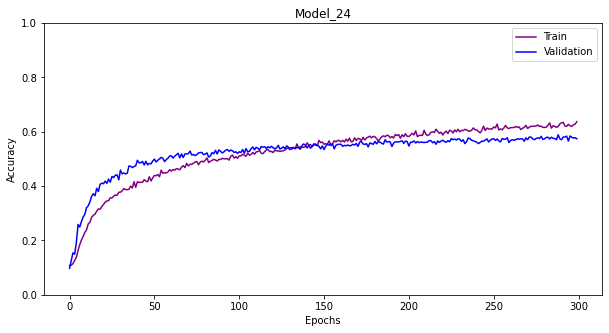

In [253]:
plt.plot(model_24history.history['accuracy'], label = 'accuracy', color='purple')
plt.plot(model_24history.history['val_accuracy'], label = 'val_accuracy', color='blue') 
plt.legend(['Train', 'Validation'])
plt.title('Model_24')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0, 1.0]);

### The Confusion matrix to display how many images are predicted correct and how many are wrong for model_24

In [254]:
predictm_24=model_24.predict(X_test2)
expectm_24=y_test2
conf_matrix_m24=confusion_matrix(y_test2.argmax(axis=1), predictm_24.argmax(axis=1))
print(conf_matrix_m24)

[[ 69  10   6   1  24  33   9  11  15   6]
 [ 11 119  23   4   7   4  34  14   5   5]
 [  6   7 123   0  23   3  16  16  14  11]
 [  3   1   1 120  13   8   2   1   9  27]
 [  9   1   6   7 117   6   2   7  13   9]
 [ 36   3   2  11  17  94   2   8  24  19]
 [  8  10  13   0  15   4 107  36   6   0]
 [ 11   4   8   1  29   4  29  93  15   5]
 [ 15   1   1  10  24  16   2   4  97  22]
 [ 10   1   1  21  12  11   0   2  12 133]]


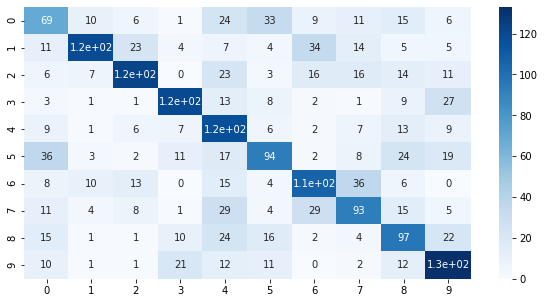

In [262]:
sns.heatmap(conf_matrix_m24, annot=True, cmap='Blues');

### Plot all Models' accuracy versus epoch graph

In [ ]:
plt.subplot(2, 2, 1)
plt.plot(model_14history.history['accuracy'], label = 'accuracy', color='purple')
plt.plot(model_14history.history['val_accuracy'], label = 'val_accuracy', color='blue') 
plt.legend(['Train', 'Validation'])
plt.title('Model_14')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.rcParams['figure.figsize']=(15,10)
plt.ylim([0, 1.0])

plt.subplot(2, 2, 2)
plt.plot(model_15history.history['accuracy'], label = 'accuracy', color='purple')
plt.plot(model_15history.history['val_accuracy'], label = 'val_accuracy', color='blue') 
plt.legend(['Train', 'Validation'])
plt.title('Model_15')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.rcParams['figure.figsize']=(15,10)
plt.ylim([0, 1.0])

plt.subplot(2, 2, 3)
plt.plot(model_17history.history['accuracy'], label = 'accuracy', color='purple')
plt.plot(model_17history.history['val_accuracy'], label = 'val_accuracy', color='blue') 
plt.legend(['Train', 'Validation'])
plt.title('Model_17')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.rcParams['figure.figsize']=(15,10)
plt.ylim([0, 1.0])

plt.subplot(2, 2, 4)
plt.plot(model_24history.history['accuracy'], label = 'accuracy', color='purple')
plt.plot(model_24history.history['val_accuracy'], label = 'val_accuracy', color='blue') 
plt.legend(['Train', 'Validation'])
plt.title('Model_24')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.rcParams['figure.figsize']=(15,10)
plt.ylim([0, 1.0]);

## Conclusion:
#### We tried many different versions of models adjusting their parameters and evaluated their accuracies, then we chose those best four models.
#### From these four models, model_14 and model_15 we can see they are overfitting since their accuracy graphs for train and validation data, they have wider gap when we increased the epoch size.

#### For the other two models, model_17 and model_24 this issue seemed to improve. The training and validation sets seemed to perform more similarly and the accuracy score for model_17 was the highest of all of the models. Although the testing accuracy or When model_14 was run with 1400 images per class the test accuracy increased to 61% and performed the best out of all of the models. If we were able to use the full dataset, we think that the accuracy would increase even more.